In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

#%matplotlib inline


# Set up three layer Lorenz 95 model as in D&B paper

In [2]:
# code based on version from https://en.wikipedia.org/wiki/Lorenz_96_model
# and ammended to match D&B paper - not sure how to initialise, paper doesn't say, so have gone 
# with forcing values for x variables and random for y and z variables.


I = 8
J = 8
K = 8

F = 20  # forcing

h = 1
c = 10
b = 10
e = 10
d = 10

gz = 1


#def Lorenz96(t, state):
def Lorenz96(t, state):
    # unpack input array
    x=state[0:K]
    y=state[K:J*K+K]
    z=state[J*K+K:I*J*K+J*K+K]
    y=y.reshape(J,K)
    z=z.reshape(I,J,K)
    
    # compute state derivatives
    dx = np.zeros((K))
    dy = np.zeros((J,K))
    dz = np.zeros((I,J,K))
    # Do the X variable
    # first the 3 edge cases: i=1,2,K-1
    dx[0]   = x[K-1] * (x[1] - x[K-2]) - x[0]   + F - h*c/b * sum(y[:,0])
    dx[1]   =   x[0] * (x[2] - x[K-1]) - x[1]   + F - h*c/b * sum(y[:,1])  
    dx[K-1] = x[K-2] * (x[0] - x[K-3]) - x[K-1] + F - h*c/b * sum(y[:,K-1])  
    # then the general case
    for k in range(2, K-1):
        dx[k] = x[k-1] * (x[k+1] - x[k-2]) - x[k] + F - h*c/b * sum(y[:,k])

    # Do the Y variable
    # first the 3 edge cases: i=1,2,K-1
    for k in range(0,K):
        dy[0,k]   = - c*b * y[1,k]   * ( y[2,k] - y[J-1,k] ) - c * y[0,k]    + h*c/b * x[k] - h*e/d * sum(z[:,0,k])
        dy[J-2,k] = - c*b * y[J-1,k] * ( y[0,k] - y[J-3,k] ) - c * y[J-2,k]  + h*c/b * x[k] - h*e/d * sum(z[:,J-2,k])
        dy[J-1,k] = - c*b * y[0,k]   * ( y[1,k] - y[J-2,k] ) - c * y[J-1,k]  + h*c/b * x[k] - h*e/d * sum(z[:,J-1,k])
        # then the general case
        for j in range(1, J-2):
            dy[j,k] = - c*b * y[j+1,k] * ( y[j+2,k] - y[j-1,k] ) - c * y[j,k]  + h*c/b * x[k] - h*e/d * sum(z[:,j,k])

    # Do the Z variable
    # first the 3 edge cases: i=1,2,K-1
    for k in range(0,K):
        for j in range (0,J):
            dz[0,j,k]   = e*d * z[I-1,j,k] * ( z[1,j,k] - z[I-2,j,k] ) - gz*e * z[0,j,k]   + h*e/d * y[j,k]
            dz[1,j,k]   = e*d * z[0,j,k]   * ( z[2,j,k] - z[I-1,j,k] ) - gz*e * z[1,j,k]   + h*e/d * y[j,k]
            dz[I-1,j,k] = e*d * z[I-2,j,k] * ( z[0,j,k] - z[I-3,j,k] ) - gz*e * z[I-1,j,k] + h*e/d * y[j,k]
            # then the general case
            for i in range(2,I-1):
                dz[i,j,k] = e*d * z[i-1,j,k] * ( z[i+1,j,k] - z[i-2,j,k] ) - gz*e * z[i,j,k] + h*e/d * y[j,k]

    # return the state derivatives
    # reshape and cat into single array
    d_state = np.concatenate((dx,dy.reshape(J*K,),dz.reshape(I*J*K,)))
    
    return d_state


In [3]:
x0 = np.zeros((K)) # ??
y0 = np.random.rand(J,K) # Random??
z0 = np.random.rand(I,J,K) # Random??

state0 = np.concatenate((x0,y0.reshape(J*K,),z0.reshape(I*J*K,)))

int_t = 0.005
#t_span = np.arange(0.0, 2000000.0, int_t)
t_span = np.arange(0.0, 20.0, int_t)
t_len=len(t_span)

#state = solve_ivp(Lorenz96, t_span, state0, method='RK45')['y']
state = odeint(Lorenz96, state0, t_span, tfirst=True)

x=state[:,0:K]
y=state[:,K:J*K+K].reshape(t_len,J,K)
z=state[:,J*K+K:I*J*K+J*K+K].reshape(t_len,I,J,K)



In [4]:
# # plot it
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot(x[:,0],x[:,1],x[:,2])
# ax.set_xlabel('$x_1$')
# ax.set_ylabel('$x_2$')
# ax.set_zlabel('$x_3$')
# plt.show()

# # plot first and second x values over time
# fig = plt.figure(figsize=(20,4))
# ax = plt.subplot(111)
# ax.plot(x[:,0])
# ax.plot(x[:,1])
# ax.plot(x[:,3])
# ax.plot(x[:,5])
# ax.plot(x[:,7])

# plt.show()


### Set up NN's

In [5]:
# Define two matching sequential NNs

# D&B use two hidden layers with 20 neurons each

H = 20 # no of nodes

h1 = nn.Sequential(nn.Linear(4, H), nn.Tanh(), 
                   nn.Linear(H, H), nn.Tanh(), 
                   nn.Linear(H, H), nn.Tanh(), 
                   nn.Linear(H, 1))
h2 = pickle.loads(pickle.dumps(h1))

no_epochs=2
# Need to normalise input and output data?!?!?


### train to first order objective

In [6]:
# Store data in training - output pairs
L95_data_1st = np.zeros((1,5))

i=0
for time in range(1, t_len, int(1/0.005)):
    # xloc = 0 case
    if i == 0:
        L95_data_1st[i,:]=x[time-1, K-2], x[time-1,K-1], x[time-1,0], x[time-1,1], x[time, 1]
        i=1
    else:
        L95_data_1st = np.vstack(( L95_data_1st, np.array([x[time-1, K-2], x[time-1,K-1], x[time-1,0],
                                                   x[time-1,1], x[time, 1]], dtype=float) ))
    # xloc = 1 case
    L95_data_1st = np.vstack(( L95_data_1st, np.array([x[time-1, K-1], x[time-1,0], x[time-1,1], 
                                               x[time-1,2], x[time, 2]], dtype=float) ))
    for xloc in range(2,K-1):
        L95_data_1st = np.vstack(( L95_data_1st, np.array([x[time-1, xloc-2], x[time-1,xloc-1], x[time-1,xloc],
                                                   x[time-1,xloc+1],x[time, xloc]], dtype=float) ))
    # xloc = K-1 case
    L95_data_1st = np.vstack(( L95_data_1st, np.array([x[time-1, K-3], x[time-1,K-2], x[time-1,K-1], 
                                               x[time-1,0], x[time, K-1]], dtype=float) ))
    
no_samples = L95_data_1st.shape[0]
print('Train to first order objective')
print('no samples : ', no_samples)

L95_tensor_1st = torch.FloatTensor(L95_data_1st)

Train to first order objective
no samples :  160


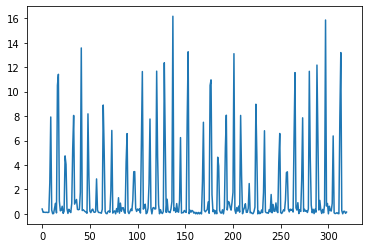

In [7]:
#opt1 = torch.optim.Adagrad(h1.parameters(), lr=0.1)
opt1 = torch.optim.SGD(h1.parameters(), lr=0.1)  # Stochastic gradient descent as optimiser
# should I be setting a 'scheduler' and add a call to scheduler.step() ?

train_loss = []
for epoch in range(no_epochs):  # in D&B paper the NN's were trained for at least 200 epochs....
    for i in range(no_samples):
        opt1.zero_grad()
        estimate = L95_tensor_1st[i,2] + h1(L95_tensor_1st[i,0:4])
        loss = (estimate - L95_data_1st[i,4]).abs().mean()  # mean absolute error
        loss.backward()
        train_loss.append(loss.item())
        opt1.step()

plt.plot(train_loss)
plt.savefig('train_loss_1storderobjective.png')

### train to second order objective

In [8]:
# Store data in training - output pairs
L95_data_2nd = np.zeros((1,9))

i=0
for time in range(2, t_len, int(1/0.005)):
    # xloc = 0 case
    if i == 0:
        L95_data_2nd[i,:] = x[time-2, K-2], x[time-2,K-1], x[time-2,0], x[time-2,1], \
                            x[time-1, K-2], x[time-1,K-1], x[time-1,0], x[time-1,1], \
                            x[time, 1]
        i=1
    else:
        L95_data_2nd = np.vstack(( L95_data_2nd,
                                   np.array([x[time-2, K-2], x[time-2,K-1], x[time-2,0], x[time-2,1],
                                             x[time-1, K-2], x[time-1,K-1], x[time-1,0], x[time-1,1],
                                             x[time, 1]], dtype=float) ))
    # xloc = 1 case
    L95_data_2nd = np.vstack(( L95_data_2nd,
                               np.array([x[time-2, K-1], x[time-2,0], x[time-2,1], x[time-2,2],
                                         x[time-1, K-1], x[time-1,0], x[time-1,1], x[time-1,2],
                                         x[time, 2]], dtype=float) ))
    for xloc in range(2,K-1):
        L95_data_2nd = np.vstack(( L95_data_2nd,
                                   np.array([x[time-2, xloc-2], x[time-2,xloc-1], x[time-2,xloc], x[time-2,xloc+1],
                                             x[time-1, xloc-2], x[time-1,xloc-1], x[time-1,xloc], x[time-1,xloc+1],
                                             x[time, xloc]], dtype=float) ))
    # xloc = K-1 case
    L95_data_2nd = np.vstack(( L95_data_2nd,
                               np.array([x[time-2, K-3], x[time-2,K-2], x[time-2,K-1], x[time-2,0],
                                         x[time-1, K-3], x[time-1,K-2], x[time-1,K-1], x[time-1,0],
                                         x[time, K-1]], dtype=float) ))

no_samples = L95_data_2nd.shape[0]
print('Train to second order objective')
print('no samples : ', no_samples)

L95_tensor_2nd = torch.FloatTensor(L95_data_2nd)

Train to second order objective
no samples :  160


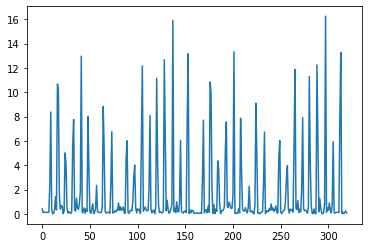

In [9]:
#opt2 = torch.optim.Adagrad(h2.parameters(), lr=0.1)
opt2 = torch.optim.SGD(h2.parameters(), lr=0.1)  # Stochastic gradient descent as optimiser
# should I be setting a 'scheduler' and add a call to scheduler.step() ?

train_loss2 = []
for epoch in range(no_epochs):  # in D&B paper the NN's were trained for at least 200 epochs....
    for i in range(no_samples):
        opt2.zero_grad()
        estimate = L95_tensor_2nd[i,6] + 0.5*( 3*h2(L95_tensor_2nd[i,4:8]) - h2(L95_tensor_2nd[i,0:4]) )
        loss = (estimate - L95_data_2nd[i,8]).abs().mean()  # mean absolute error
        loss.backward()
        train_loss2.append(loss.item())
        opt2.step()
    
plt.plot(train_loss2);
plt.savefig('train_loss_2ndorderobjective.png')

### Look at learned functions

### Test in simple integrators


In [10]:
def first_order_integrator(init, h, num_steps):
    z = np.array([init])
    for t in range(num_steps):
        deltaz = np.zeros((K))
        #xloc = 0 case
        deltaz[0] = ( z[-1,0] + h(torch.FloatTensor([[[ z[-1, K-2], x[-1,K-1], x[-1,0], x[-1,1] ]]] )) ).item()
        # xloc = 1 case
        deltaz[1] = ( z[-1,1] + h(torch.FloatTensor([[[ z[-1, K-1], x[-1,0], x[-1,1], x[-1,2] ]]] )) ).item()
        # xloc = 2 to K-2 cases
        for xloc in range(2,K-1):
            deltaz[xloc] = ( z[-1,xloc] + h(torch.FloatTensor([[[ z[-1, xloc-2], x[-1,xloc-1], x[-1,xloc], x[-1,xloc+1] ]]] )) ).item()
        # xloc = K-1 case
        deltaz[K-1] = ( z[-1,K-1] + h(torch.FloatTensor([[[ z[-1, K-3], x[-1,K-2], x[-1,K-1], x[-1,0] ]]] )) ).item()
        z_next = z + deltaz
        z=np.vstack((z, z_next))
        
    return np.array(z)



In [ ]:
train1test1 = first_order_integrator(x[0,:], h1, int(1/int_t))


In [ ]:
train2test1 = first_order_integrator(x[0,:], h2, int(1/int_t))

In [ ]:
# Plot it..

plt.plot(x[:int(4/int_t),4])
plt.plot(train1test1[:,4])
plt.plot(train2test1[:,4])
plt.legend(['data', '1st', '2nd'])
plt.title('first order integrator performance')
plt.ylim(-30, 30)
plt.show()
plt.savefig('1storder_int_performance.png')
plt.close()

In [ ]:
def second_order_integrator(init, h, num_steps):
    z = first_order_integrator(init, h, 1)
    for t in range(num_steps-1):
        new = np.zeros((K))
        # xloc = 0 case
        new[0] = ( z[-1,0] + 0.5 * 
                 ( 3 * h(torch.FloatTensor([[[ z[-1, K-2], x[-1,K-1], x[-1,0], x[-1,1] ]]] ))
                     - h(torch.FloatTensor([[[ z[-2, K-2], x[-2,K-1], x[-2,0], x[-2,1] ]]] )) ).item() )
        # xloc = 1 case
        new[1] = ( z[-1,1] + 0.5 * 
                 ( 3 * h(torch.FloatTensor([[[ z[-1, K-1], x[-1,0], x[-1,1], x[-1,2] ]]] ))
                     - h(torch.FloatTensor([[[ z[-2, K-1], x[-2,0], x[-2,1], x[-2,2] ]]] )) ).item() )
        # xloc = 2 to K-2 cases
        for xloc in range(2,K-1):
            new[xloc] = ( z[-1,xloc] + 0.5 *
                        ( 3 * h(torch.FloatTensor([[[ z[-1, xloc-2], x[-1,xloc-1], x[-1,xloc], x[-1,xloc+1] ]]] ))
                            - h(torch.FloatTensor([[[ z[-2, xloc-2], x[-2,xloc-1], x[-2,xloc], x[-2,xloc+1] ]]] )) ).item() )
        # xloc = K-1 case
        new[K-1] = ( z[-1,K-1] + 0.5 *
                   ( 3 * h(torch.FloatTensor([[[ z[-1, K-3], x[-1,K-2], x[-1,K-1], x[-1,0] ]]] )) 
                       - h(torch.FloatTensor([[[ z[-2, K-3], x[-2,K-2], x[-2,K-1], x[-2,0] ]]] )) ).item() )
         
        z=np.vstack((z, new))
        
    return np.array(z)

train1test2 = second_order_integrator(x[0,:], h1, 4/int_t)
train2test2 = second_order_integrator(x[0,:], h2, 4/int_t)


In [ ]:
# Plot it..

plt.plot(x[:4/int_t,4])
plt.ylim(-30,30)
plt.plot(train1test2[:,4])
plt.plot(train2test2[:,4])
plt.legend(['data', '1st', '2nd']);
plt.title('second order integrator performance');
plt.ylim(-30, 30)
plt.show()
plt.savefig('1storder_int_performance.png')
plt.close()

# Toy Model 

In [ ]:
# toy_sequence = np.array([1,2,6,3,10,5,6], dtype=float)

# data_simple = torch.FloatTensor(np.stack((toy_sequence[:-1], toy_sequence[1:])).T)
# data_simple

In [ ]:
# import pickle

# H = 20

# h1 = nn.Sequential(nn.Linear(1, H), nn.ReLU(), 
# #                    nn.Linear(H, H), nn.ReLU(), 
#                    nn.Linear(H, H), nn.ReLU(), 
#                    nn.Linear(H, 1))
# h2 = pickle.loads(pickle.dumps(h1))

In [ ]:
# domain = np.linspace(-10, 10)

# out = h1(torch.FloatTensor(domain)[:,None]).detach().numpy()
# plt.plot(domain, out)
# out = h2(torch.FloatTensor(domain)[:,None]).detach().numpy()
# plt.plot(domain, out)

### Training to first-order objective

In [ ]:
# opt1 = torch.optim.Adagrad(h1.parameters(), lr=0.1)

In [ ]:
# print(data_simple)
# # data_simple[:,0][:,None] + h1(data_simple[:,0][:,None]), 
# print(data_simple[:,0])
# print(data_simple[:,0][:,None])

In [ ]:
# train_loss = []
# for i in range(20000):
#     opt1.zero_grad()
#     estimate = data_simple[:,0][:,None] + h1(data_simple[:,0][:,None])
#     loss = (estimate - data_simple[:,1][:,None]).abs().mean()
#     loss.backward()
#     train_loss.append(loss.item())
#     opt1.step()
    
# plt.plot(train_loss)

In [ ]:
# plt.plot(train_loss[200:])

### Training to second-order objective

In [ ]:
# opt2 = torch.optim.Adagrad(h2.parameters(), lr=0.1)

In [ ]:
# data = torch.FloatTensor(np.stack((toy_sequence[:-2], toy_sequence[1:-1], toy_sequence[2:])).T)

In [ ]:
# train_loss2 = []

# for i in range(20000):
#     opt2.zero_grad()
#     estimate = data[:,1][:,None] + 0.5*(3*h2(data[:,1][:,None]) - h2(data[:,0][:,None]))
#     loss = (estimate - data[:,2][:,None]).abs().mean()
#     loss.backward()
#     train_loss2.append(loss.item())
#     opt2.step()
    
# plt.plot(train_loss2);

### Look at the learned functions

In [ ]:
# domain = np.linspace(-3, 3)

# out = h1(torch.FloatTensor(domain)[:,None]).detach().numpy()
# plt.plot(domain, out)
# out = h2(torch.FloatTensor(domain)[:,None]).detach().numpy()
# plt.plot(domain, out)
# plt.legend(['1st order', '2nd order']);

### Test use of each in "simple" integrator

In [ ]:
# def simple_integrator(init, h, num_steps):
#     z = [init]
#     for t in range(num_steps):
#         z.append((z[-1] + h(torch.FloatTensor([[z[-1]]]))).item())
#     return np.array(z)


# train1test1 = simple_integrator(toy_sequence[0], h1, len(toy_sequence)-1)
# train2test1 = simple_integrator(toy_sequence[0], h2, len(toy_sequence)-1)

# plt.plot(toy_sequence)
# plt.plot(train1test1)
# plt.plot(train2test1)
# #plt.ylim(ylim)
# # plt.xlim(700, 1000)
# plt.legend(['data', '1st', '2nd']);
# plt.title('first order integrator performance');

In [ ]:
# def second_order_integrator(init, h, num_steps):
#     z = simple_integrator(init, h, 1).tolist()
#     for t in range(num_steps-1):
#         z.append((z[-1] + 0.5*(3*h(torch.FloatTensor([[z[-1]]])) - h(torch.FloatTensor([[z[-2]]])))).item())
#     return np.array(z)

# train1test2 = second_order_integrator(toy_sequence[0], h1, len(toy_sequence)-1)
# train2test2 = second_order_integrator(toy_sequence[0], h2, len(toy_sequence)-1)

# plt.plot(toy_sequence)
# #ylim = np.array(plt.ylim())*1.5
# plt.plot(train1test2)
# plt.plot(train2test2)
# #plt.ylim(ylim);
# # plt.xlim(700, 1000)
# plt.legend(['data', '1st', '2nd']);
# plt.title('second order integrator performance');